In [157]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

Found 730 images belonging to 2 classes.
Found 269 images belonging to 2 classes.


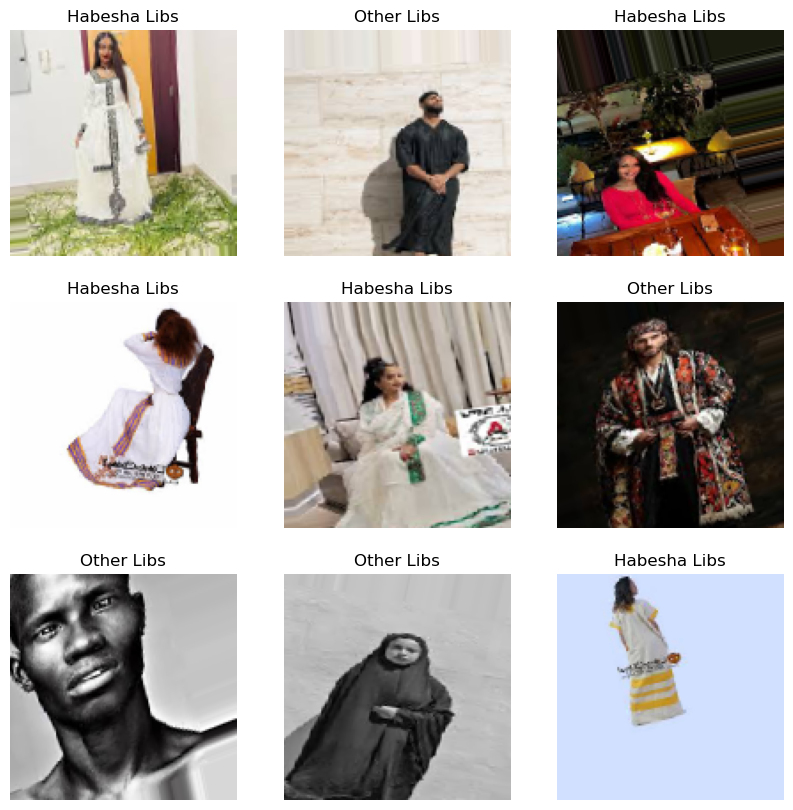

In [161]:
# Define directories
train_dir = '../data/training'
val_dir = '../data/validation'

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation Data (No Augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Visualize sample images
for X_batch, y_batch in train_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
        plt.title("Habesha Libs" if y_batch[i] == 0 else "Other Libs")
        plt.axis('off')
    plt.show()
    break


In [265]:
# Function to preprocess the image (ensure it's in RGB mode and handle transparency)
def preprocess_image(image_path):
    # Load image and convert it to 'RGB' mode explicitly
    img = load_img(image_path, target_size=(128, 128))
    
    # Check if the image has an alpha channel (transparency) and convert to 'RGB' or 'RGBA'
    if img.mode == 'RGBA':
        img = img.convert('RGB')  # Convert to RGB if it has transparency
    elif img.mode != 'RGB':
        img = img.convert('RGB')  # Convert any non-RGB image to RGB
    
    # Convert image to array and normalize
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Build the Model
model = Sequential([
    Input(shape=(128, 128, 3)),  # Explicit Input layer to avoid warnings
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Suitable for binary classification
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define Callbacks
os.makedirs('../models', exist_ok=True)
callbacks = [
    ModelCheckpoint('../models/habesha_classifier_best.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Train the Model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

# Save the Final Model using .keras format
model.save('../models/habesha_classifier_final.keras')


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 683ms/step - accuracy: 0.5141 - loss: 0.7477 - val_accuracy: 0.5836 - val_loss: 0.6740
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 639ms/step - accuracy: 0.5841 - loss: 0.6741 - val_accuracy: 0.6617 - val_loss: 0.6745
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 613ms/step - accuracy: 0.6736 - loss: 0.6003 - val_accuracy: 0.5539 - val_loss: 0.7832
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step - accuracy: 0.6936 - loss: 0.6025 - val_accuracy: 0.7138 - val_loss: 0.6264
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 617ms/step - accuracy: 0.7370 - loss: 0.5315 - val_accuracy: 0.7100 - val_loss: 0.6202
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.7736 - loss: 0.5292 - val_accuracy: 0.7361 - val_loss: 0.6293
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 625ms/step - accuracy: 0.7368 - loss: 0.5383 - val_accuracy: 0.7472 - val_loss: 0.6055
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 619ms/step - accuracy: 0.7652 - loss: 0.5188 - val_accu

In [181]:
# Load the Best Model
model = load_model('../models/habesha_classifier_final.h5')

# Evaluate on Validation Data
val_generator.reset()
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Predictions
val_generator.reset()
predictions = (model.predict(val_generator) > 0.5).astype(int)
true_labels = val_generator.classes

# Classification Report
print(classification_report(true_labels, predictions, target_names=['Habesha Libs', 'Other Libs']))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7405 - loss: 0.5251
Validation Accuracy: 71.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
              precision    recall  f1-score   support

Habesha Libs       0.73      0.80      0.76       157
  Other Libs       0.68      0.58      0.62       112

    accuracy                           0.71       269
   macro avg       0.70      0.69      0.69       269
weighted avg       0.71      0.71      0.71       269

Confusion Matrix:
[[126  31]
 [ 47  65]]


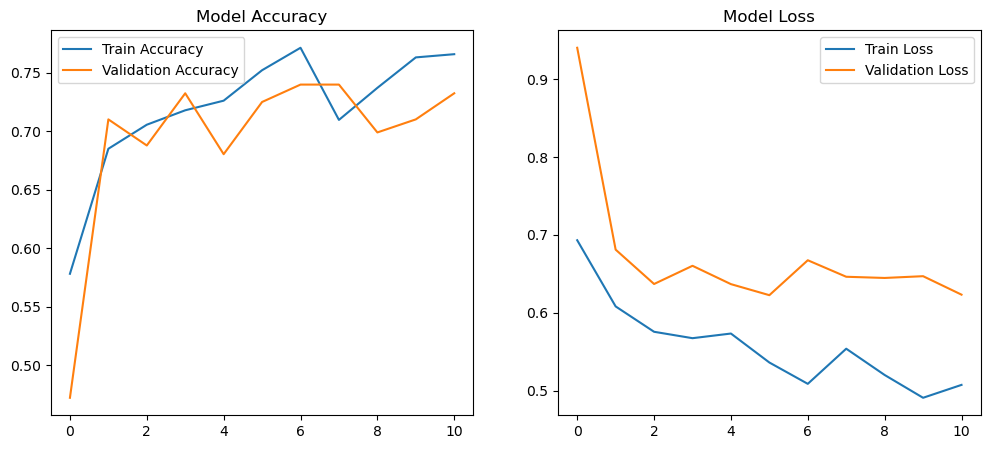

In [183]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: Worn Habesha Libs


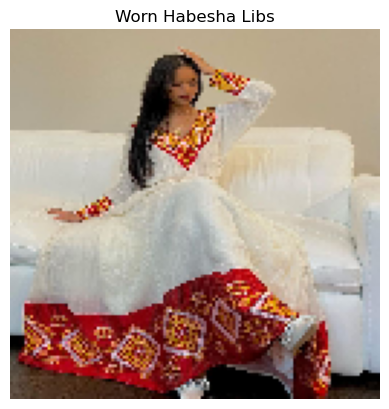

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Worn Non Habesha Libs


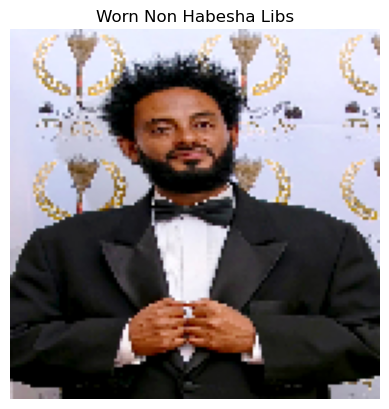

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: Worn Habesha Libs


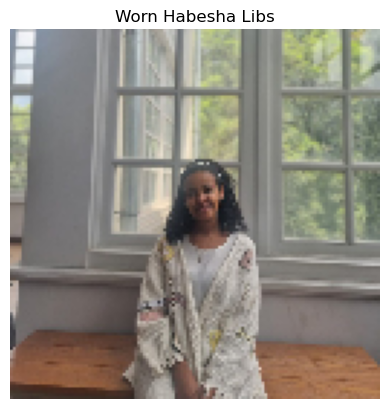

In [263]:
def classify_image(image_path, model):
    # Load image
    img = load_img(image_path, target_size=(128, 128))
    img = img_to_array(img) / 255.0  # Normalize the image to [0, 1]

    # Expand dimensions for model prediction
    img = np.expand_dims(img, axis=0)

    # Predict the class
    prediction = model.predict(img)
    label = 'Worn Habesha Libs' if prediction < 0.5 else 'Worn Non Habesha Libs'
    print(f"Prediction: {label}")
    
    # Display the image
    plt.imshow(img[0])
    plt.title(label)
    plt.axis('off')
    plt.show()

# Test with a sample image
classify_image('../data/test/eritrean.jpg', model)
classify_image('../data/test/no-habesha.jpg', model)
classify_image('../data/test/photo_2024-08-13_13-47-05.jpg', model)